<a href="https://colab.research.google.com/github/bnanik/Shared_Task_SemEval2023/blob/main/Baseline_SVM_LR_RF_TF_IDF_stratified_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To Run the code below, the only requirement is to upload the training data file "train_all_tasks.csv" to colab (/content/train_all_tasks.csv). The file can be downloaded from CodaLab website.

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import re
import nltk
import spacy
import string

import statistics

from nltk.stem.porter import PorterStemmer

ImportError: cannot import name 'cross_validate' from 'sklearn' (c:\ProgramData\Anaconda3\lib\site-packages\sklearn\__init__.py)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DearUser\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DearUser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DearUser\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DearUser\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DearUser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load dataset

In [8]:
data = pd.read_csv('./data/train_all_tasks.csv')
#data = pd.read_csv('/content/train_all_tasks.csv')
df = data.filter(['text', 'label_sexist'])
df.columns = ['text', 'label']
df["text"] = df["text"].astype(str)
df.head(2)

,text,label
0,"Damn, this writing was pretty chaotic",not sexist
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist


### Data pre-processing


In [9]:
#import string
#string.punctuation
#   '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'

### Emotics Removal

In [55]:
# Thanks : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py for Emoticons and
# Thanks : https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt)) for list of chat words

EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
# Chat words removal
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

In [56]:

# Punctuation removal:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

#Stop words removal:
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# Stemming
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

# Lemmatization
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

# Emojis Removal
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Emoticons removal
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

# URL and Html tag removal
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    t= url_pattern.sub(r'', text)
    html=re.compile(r'<.*?>') 
    return html.sub(r'',t) #Removing html tags

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [57]:
from string import punctuation

#cleaning steps:
    # 0- lowercase
    # 1- lowercase, punctuation, stopwords
    # 2- lowercase, punctuation, stopwords,lemma,,url/tags
    # 3- lowercase, punctuation, stopwords,lemma,,url/tags,emoji,chatwords
    

# step 0
def clean_text0(text):
    text = text.lower()
    return text

# step 1
def clean_text1(text):
    
    text = text.lower()
    text= remove_punctuation(text)
    text=remove_stopwords(text)
  
    return text

# step 2
def clean_text2(text):
    # Chat words removal
    chat_words_map_dict = {}
    chat_words_list = []
    for line in chat_words_str.split("\n"):
        if line != "":
            cw = line.split("=")[0]
            cw_expanded = line.split("=")[1]
            chat_words_list.append(cw)
            chat_words_map_dict[cw] = cw_expanded
    chat_words_list = set(chat_words_list)
    text = text.lower()
    text= remove_punctuation(text)
    text=remove_stopwords(text)
    #text=stem_words(text)
    text=lemmatize_words(text)
    text= remove_urls(text)
    return text



# step 3
def clean_text3(text):
    # Chat words removal
    chat_words_map_dict = {}
    chat_words_list = []
    for line in chat_words_str.split("\n"):
        if line != "":
            cw = line.split("=")[0]
            cw_expanded = line.split("=")[1]
            chat_words_list.append(cw)
            chat_words_map_dict[cw] = cw_expanded
    chat_words_list = set(chat_words_list)
    text = text.lower()
    text= remove_punctuation(text)
    text=remove_stopwords(text)
    #text=stem_words(text)
    text=lemmatize_words(text)
    text=remove_urls(text)
    text=remove_emoji(text)
    text=convert_emoticons(text)
    text=chat_words_conversion(text)
    return text


In [58]:

# Finalizing preprocessing step:
cleaning_step=0
if cleaning_step==0:
    # cleaning step 0
    df["cleaned_text"] = df["text"].apply(lambda x: clean_text0(x))
elif cleaning_step==1:
    # cleaning step 1
    df["cleaned_text"] = df["text"].apply(lambda x: clean_text1(x))
elif cleaning_step==2:
    # cleaning step 2
    df["cleaned_text"] = df["text"].apply(lambda x: clean_text2(x))
elif cleaning_step==3:
    # cleaning step 3
    df["cleaned_text"] = df["text"].apply(lambda x: clean_text3(x))


df = df.filter(["cleaned_text", "label"])
df.columns = ['text', 'label']
df.head()

,text,label
0,damn write pretti chaotic,not sexist
1,yeah appar bunch misogynist virgin one turn ga...,not sexist
2,fuck woman still mp,not sexist
3,understand know right time know isnt enough mo...,not sexist
4,surpriz didnt stop rape woman,not sexist


In [41]:
df.head(30)

,text,label
0,damn write pretti chaotic,not sexist
1,yeah appar bunch misogynist virgin one turn ga...,not sexist
2,fuck woman still mp,not sexist
3,understand know your right time know isnt enou...,not sexist
4,surpriz didnt stop rape woman,not sexist
5,yeah order keep benefit good tommorow tell cou...,not sexist
6,hahaha wish would live truth cut shit wouldnt ...,not sexist
7,head mod say talk make post won’t tell anyon t...,not sexist
8,insid wallet cash bank card credit card debit ...,sexist
9,definit didn’t go much detail happen put stop ...,not sexist


### Training SVM/RandomForest/LogisticRegression and Naive Bayesian model using stratified Cross Validation:

In [20]:
Encoder = LabelEncoder()
X = df['text']
y = Encoder.fit_transform(df['label'])

In [38]:
def erroranalysis(yp):
  for item in yp:
    if (item[1]!=item[2]).any():
      print(item[0], "actual:{}  pred:{}".format(item[1],item[2]),'\n')

d=[]
d.append(('sss',1,1))
d.append(('ddf',0,1))
#erroranalysis(d)

In [43]:
from matplotlib import pyplot as plt

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

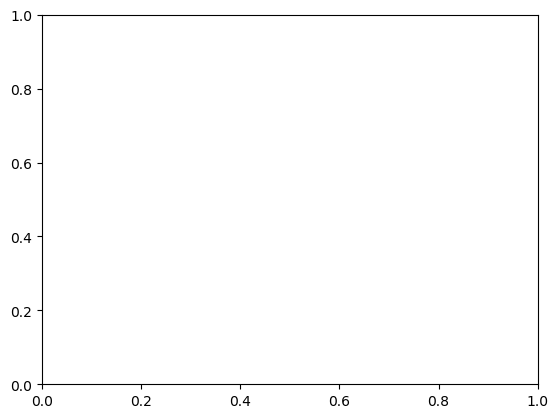

In [45]:
k=2

skf = model_selection.StratifiedKFold(n_splits=k, shuffle=True, random_state=11)  # 20% for dev set in each fold

# using TF-IDF vectorizer, 1-gram and 2-gram settings
Tfidf_vect = TfidfVectorizer(max_features=10000,ngram_range=(1,2)) 
Tfidf_vect.fit(X)


lrClassifier = LogisticRegression( multi_class='ovr')#C=5e1, solver='saga', multi_class='ovr', random_state=17, n_jobs=4) #optimizer: sag, saga, lbfgs   multi-class=ovr -> for binary classification
svmClassifier=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
#svmClassifier_s=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
rfClassifier=RandomForestClassifier()#max_depth=50, random_state=0)

models=[lrClassifier,svmClassifier,rfClassifier]
#models=[svmClassifier]
for model in models:
  accu_skf = []
  f1_skf = []
  precision_skf = []
  recall_skf = []
  p=[]

  for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = Tfidf_vect.transform(X[train_index]), Tfidf_vect.transform(X[test_index]) 
    y_train_fold, y_test_fold = y[train_index], y[test_index] 
    model.fit(X_train_fold, y_train_fold)

    pred = model.predict(X_test_fold)
     
    #features_names=Tfidf_vect.inverse_transform(X[test_index])
    #f_importances(model.coef_, features_names)  
    accu_skf.append(metrics.accuracy_score(pred, y_test_fold))
    f1_skf.append(metrics.f1_score(pred, y_test_fold, average = 'macro'))
    precision_skf.append(metrics.precision_score(pred, y_test_fold, average = 'macro'))
    recall_skf.append(metrics.recall_score(pred, y_test_fold, average = 'macro'))

  
  
  
  print('model name: {} \n accuracy:{}  f1: {}   \n precision:   {}   recall :{}'.format(type(model).__name__,statistics.mean(accu_skf),statistics.mean(f1_skf),statistics.mean(precision_skf),statistics.mean(recall_skf)))


## Training SVM model without stratified Cross Validation:
## Prepare Train and Test Data sets

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['text'],df['label'],test_size=0.3)

# Encoding

In [ ]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(Train_Y)
y_test = Encoder.fit_transform(Test_Y)

# Word Vectorization (TF-IDF)

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['text'])
X_train = Tfidf_vect.transform(Train_X)
X_test = Tfidf_vect.transform(Test_X)

## Classifier - SVM

In [ ]:

# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)


In [ ]:
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(predictions_SVM, y_test))
print("F1:",metrics.f1_score(predictions_SVM, y_test, average="macro"))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(predictions_SVM, y_test, average="macro"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(predictions_SVM, y_test, average="macro"))

Accuracy: 0.8378571428571429
F1: 0.7211712989126149
Precision: 0.6864923831405788
Recall: 0.857807211686592
